In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from model import C2F_TCN
from dataset import AugmentDataset, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='6'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=50,
    learning_rate=1e-4,
    weight_decay=3e-3,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=10,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=2,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-length/",
    project_name="breakfast-split-2",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 50, 'learning_rate': 0.0001, 'weight_decay': 0.003, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 10, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 2, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-length/', 'project_name': 'breakfast-split-2', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split2.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split2.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_split':

In [7]:
traindataset = AugmentDataset(config, fold='train', fold_file_name=config.semi_supervised_split, augment=False)

Number of videos logged in train fold is 257
Number of videos not found in train fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=7, collate_fn=collate_fn_override,
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = pickle.load(open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "rb"))
# loaded_vidid_selected_frames

In [11]:
video_id_boundary_frames = pickle.load(open("dump_dir/video_id_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [12]:
loaded_mean_var_actions = pickle.load(open("dump_dir/mean_var_actions.pkl", "rb"))

In [13]:
prob_video_each_segment_dict = {}

In [14]:
def get_possion_prob(cur_len, cur_class, min_len):
    mean_class, std_class = loaded_mean_var_actions[cur_class]   
    prob = (cur_len * np.log(mean_class + 1e-5))
    prob = prob - mean_class
    prob = prob - np.sum(np.log(np.arange(1, cur_len, 1)))
    return prob

get_possion_prob(20, 20, 10)

0.48488744950308416

In [15]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):
        
        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[cur_ele]
        label_next_ele = labels[next_ele]
        prob_list = []
        for ele in range(cur_ele, next_ele, 1):
            start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
            sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
            sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
            
            len_cur_class = ele - cur_boundary
            len_prob = get_possion_prob(len_cur_class, label_cur_ele.item(), cur_ele)
            prob_list.append((sum_window_class_1 + sum_window_class_2) + len_prob.item())
            
        prob_list = torch.softmax(torch.stack(prob_list), dim=0)
        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob_list.detach().cpu().numpy()).item())
        prob_each_segment.append(prob_list)
    
    return prob_each_segment

In [16]:
# selected_frames = torch.tensor([2, 10, 17, 21])
# cur_vid_feat = torch.randn((27, 48))
# labels = torch.tensor([47, 47, 47, 47, 47, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10])
# # print(len(labels))
# probs_all_segs = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
# print(probs_all_segs)

In [17]:
def calculate_element_probb(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid]
        prob_video = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [18]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid]
        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames[0]
        if start_ele_idx > 0:
            start_ele_label_idx = labels[selected_frames[0]]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob)
        
        for i, cur_ele in enumerate(selected_frames[:-1]):
            next_ele = selected_frames[i + 1]
            label_cur_ele = labels[cur_ele]
            label_next_ele = labels[next_ele]

            count = 0
            for ele in range(cur_ele, next_ele, 1):
                start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
                sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
                sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
                current_vid_prob_arr.append((sum_window_class_1 + sum_window_class_2)  * (prob_each_video[i][count].item()))
                count = count + 1
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = labels[selected_frames[-1]]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames[-1] - 1, :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob)
            
        loss_arr.append(torch.stack(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr
#     return loss_arr

In [19]:
def get_estimated_boundaries():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames, video_id_boundary_frames
    estimated_boundary_dict = {}
    for ele in video_id_boundary_frames.keys():
        
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        selected_ele_list = loaded_vidid_selected_frames[ele]
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_ele_list[i], selected_ele_list[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = int(estimated_boundary.item() + 1e-5)
            
            if (estimated_boundary < selected_ele_list[i]) or (estimated_boundary > selected_ele_list[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [20]:
def get_boundary_err():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = video_id_boundary_frames[ele][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"From boundary avergage accuracy = {correct * 100.0 / total:.3f}")


In [21]:
set_seed()
model = C2F_TCN(n_channels=config.feature_size, n_classes=config.num_class).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=3e-3)

# Requires loaded_vidid_selected_frames, boundaries_dict
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [ ]:
for epoch in range(2000):
    if epoch % 5 == 0:
        model.eval()
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0
        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item[0] = item[0].to(device)
                item[1] = item[1].to(device)
                item[2] = item[2].to(device)
                y, _, features = model(item[0].permute(0,2,1))
                prob = torch.softmax(y, dim=1)
                prob = prob.permute(0,2,1)
                calculate_element_probb(prob, item[1], item[5], item[2])
                
                src_mask = torch.arange(item[2].shape[1], device=item[2].device)[None, :] < item[1][:, None]
                pred = torch.argmax(prob, dim=2)
                correct += float(torch.sum((pred == item[2]) * src_mask).item())
                total += float(torch.sum(src_mask).item())
        print(f"Accuracy calculated with probabilities {correct * 100.0 / total: .3f}")
        get_boundary_err()
    model.train()
    print("Starting Maximization")
    for i, item in enumerate(trainloader):
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        
        optimizer.zero_grad()
        y, _, features = model(item[0].permute(0,2,1))
        prob = torch.softmax(y, dim=1)
        prob = prob.permute(0,2,1)
        loss, _ = get_estimated_loss(prob, item[1], item[5], item[2].to(device))
        loss.backward()
        optimizer.step()
        if i%5==0:
            print(f"Current loss {loss.item()}")

Calculating Expectation


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Accuracy calculated with probabilities  4.331
Boundary avergage error = 23.623
From boundary avergage accuracy = 71.583
Starting Maximization
Current loss 4.500397682189941
Current loss 3.9522225856781006
Starting Maximization
Current loss 3.542443037033081
Current loss 3.298313617706299
Starting Maximization
Current loss 3.3460781574249268
Current loss 3.37951397895813
Starting Maximization
Current loss 2.7627980709075928
Current loss 2.916463851928711
Starting Maximization
Current loss 2.6681737899780273
Current loss 2.8307340145111084
Calculating Expectation
Accuracy calculated with probabilities  29.504
Boundary avergage error = 20.495
From boundary avergage accuracy = 74.281
Starting Maximization
Current loss 2.1670615673065186
Current loss 2.446486473083496
Starting Maximization
Current loss 1.9621684551239014
Current loss 2.167384386062622
Starting Maximization
Current loss 2.003248929977417
Current loss 2.380903959274292
Starting Maximization
Current loss 1.711546778678894
Curr

Current loss 1.2884067296981812
Starting Maximization
Current loss 0.25607582926750183
Current loss 0.5731736421585083
Starting Maximization
Current loss 0.5038304924964905
Current loss 0.5800659656524658
Starting Maximization
Current loss 0.35758325457572937
Current loss 0.5172205567359924
Starting Maximization
Current loss 0.3142220377922058
Current loss 0.30989351868629456
Calculating Expectation
Accuracy calculated with probabilities  74.617
Boundary avergage error = 16.010
From boundary avergage accuracy = 79.078
Starting Maximization
Current loss 0.28496482968330383
Current loss 0.5106310248374939
Starting Maximization
Current loss 0.2656427025794983
Current loss 0.9811553359031677
Starting Maximization
Current loss 0.28064894676208496
Current loss 0.4958339035511017
Starting Maximization
Current loss 0.290467768907547
Current loss 0.42270323634147644
Starting Maximization
Current loss 0.2685008645057678
Current loss 0.4003461003303528
Calculating Expectation
Accuracy calculated 

Current loss 0.7323815226554871
Starting Maximization
Current loss 0.20623154938220978
Current loss 0.38072365522384644
Calculating Expectation
Accuracy calculated with probabilities  74.100
Boundary avergage error = 16.020
From boundary avergage accuracy = 79.722
Starting Maximization
Current loss 0.20802028477191925
Current loss 0.2941533029079437
Starting Maximization
Current loss 0.19556120038032532
Current loss 0.29695776104927063
Starting Maximization
Current loss 0.1731422245502472
Current loss 0.7160391211509705
Starting Maximization
Current loss 0.16490817070007324
Current loss 0.43030157685279846
Starting Maximization
Current loss 0.2187129110097885
Current loss 0.7159177660942078
Calculating Expectation
Accuracy calculated with probabilities  77.797
Boundary avergage error = 15.670
From boundary avergage accuracy = 80.901
Starting Maximization
Current loss 0.22637532651424408
Current loss 0.7007337808609009
Starting Maximization
Current loss 0.2008368968963623
Current loss 0

Current loss 0.1663092076778412
Calculating Expectation
Accuracy calculated with probabilities  80.633
Boundary avergage error = 15.523
From boundary avergage accuracy = 81.464
Starting Maximization
Current loss 0.08537165075540543
Current loss 0.22097642719745636
Starting Maximization
Current loss 0.09358320385217667
Current loss 0.23873162269592285
Starting Maximization
Current loss 0.11713918298482895
Current loss 0.17618291079998016
Starting Maximization
Current loss 0.11943848431110382
Current loss 0.30808180570602417
Starting Maximization
Current loss 0.11433641612529755
Current loss 0.18313796818256378
Calculating Expectation
Accuracy calculated with probabilities  79.735
Boundary avergage error = 15.523
From boundary avergage accuracy = 81.400
Starting Maximization
Current loss 0.1228361427783966
Current loss 0.17975033819675446
Starting Maximization
Current loss 0.10639148950576782
Current loss 0.2455029934644699
Starting Maximization
Current loss 0.13020743429660797
Current l

Accuracy calculated with probabilities  81.177
Boundary avergage error = 15.229
From boundary avergage accuracy = 82.208
Starting Maximization
Current loss 0.08086355030536652
Current loss 0.15089541673660278
Starting Maximization
Current loss 0.09370653331279755
Current loss 0.429473340511322
Starting Maximization
Current loss 0.10024204105138779
Current loss 0.1586468666791916
Starting Maximization
Current loss 0.1142328605055809
Current loss 0.1913808435201645
Starting Maximization
Current loss 0.11530978232622147
Current loss 0.22513453662395477
Calculating Expectation
Accuracy calculated with probabilities  80.767
Boundary avergage error = 15.223
From boundary avergage accuracy = 82.383
Starting Maximization
Current loss 0.09484588354825974
Current loss 0.3661954700946808
Starting Maximization
Current loss 0.09728184342384338
Current loss 0.15429753065109253
Starting Maximization
Current loss 0.15999825298786163
Current loss 0.24584828317165375
Starting Maximization
Current loss 0

Current loss 0.13306722044944763
Current loss 0.2768113911151886
Starting Maximization
Current loss 0.14057448506355286
Current loss 0.3136903643608093
Starting Maximization
Current loss 0.131151020526886
Current loss 0.21028487384319305
Starting Maximization
Current loss 0.12576903402805328
Current loss 0.342025488615036
Starting Maximization
Current loss 0.13192157447338104
Current loss 0.5689588189125061
Calculating Expectation
Accuracy calculated with probabilities  74.016
Boundary avergage error = 15.063
From boundary avergage accuracy = 82.241
Starting Maximization
Current loss 0.21213823556900024
Current loss 0.7480095028877258
Starting Maximization
Current loss 0.37149181962013245
Current loss 0.28234171867370605
Starting Maximization
Current loss 0.29307371377944946
Current loss 0.4693942070007324
Starting Maximization
Current loss 0.2213653326034546
Current loss 0.7617315053939819
Starting Maximization
Current loss 0.19732673466205597
Current loss 0.6140741109848022
Calculati

Current loss 0.10134215652942657
Current loss 0.22907768189907074
Starting Maximization
Current loss 0.09724748879671097
Current loss 0.13818927109241486
Starting Maximization
Current loss 0.10283789783716202
Current loss 0.2735396921634674
Starting Maximization
Current loss 0.09667345136404037
Current loss 0.3249515891075134
Calculating Expectation
Accuracy calculated with probabilities  80.646
Boundary avergage error = 15.293
From boundary avergage accuracy = 82.532
Starting Maximization
Current loss 0.09113519638776779
Current loss 0.26689785718917847
Starting Maximization
Current loss 0.09996652603149414
Current loss 0.1718372106552124
Starting Maximization
Current loss 0.0912107527256012
Current loss 0.19434300065040588
Starting Maximization
Current loss 0.10348477959632874
Current loss 0.1673484891653061
Starting Maximization
Current loss 0.09897764027118683
Current loss 0.19422030448913574
Calculating Expectation
Accuracy calculated with probabilities  81.423
Boundary avergage e

Current loss 0.08095301687717438
Current loss 0.4161326587200165
Starting Maximization
Current loss 0.09176845103502274
Current loss 0.149849534034729
Starting Maximization
Current loss 0.11350411921739578
Current loss 0.22459517419338226
Calculating Expectation
Accuracy calculated with probabilities  82.315
Boundary avergage error = 15.005
From boundary avergage accuracy = 83.000
Starting Maximization
Current loss 0.07245878875255585
Current loss 0.17769721150398254
Starting Maximization
Current loss 0.08955305069684982
Current loss 0.20373903214931488
Starting Maximization
Current loss 0.09009352326393127
Current loss 0.22439801692962646
Starting Maximization
Current loss 0.07608504593372345
Current loss 0.15024340152740479
Starting Maximization
Current loss 0.08195603638887405
Current loss 0.19067442417144775
Calculating Expectation
Accuracy calculated with probabilities  81.887
Boundary avergage error = 15.063
From boundary avergage accuracy = 82.779
Starting Maximization
Current l

Current loss 0.0697072222828865
Current loss 0.11073890328407288
Starting Maximization
Current loss 0.06880254298448563
Current loss 0.08789126574993134
Starting Maximization
Current loss 0.062343623489141464
Current loss 0.23545289039611816
Starting Maximization
Current loss 0.06715833395719528
Current loss 0.08892969787120819
Starting Maximization
Current loss 0.07383548468351364
Current loss 0.100448377430439
Calculating Expectation
Accuracy calculated with probabilities  81.821
Boundary avergage error = 15.303
From boundary avergage accuracy = 82.328
Starting Maximization
Current loss 0.06167599931359291
Current loss 0.07827923446893692
Starting Maximization
Current loss 0.05906550586223602
Current loss 0.10535881668329239
Starting Maximization
Current loss 0.05618627369403839
Current loss 0.1045568585395813
Starting Maximization
Current loss 0.06416486203670502
Current loss 0.10089825838804245
Starting Maximization
Current loss 0.0596424825489521
Current loss 0.10759154707193375
C

Current loss 0.10755160450935364
Starting Maximization
Current loss 0.07064361125230789
Current loss 0.1710071563720703
Starting Maximization
Current loss 0.06969726830720901
Current loss 0.1449824869632721
Starting Maximization
Current loss 0.07245821505784988
Current loss 0.14756983518600464
Starting Maximization
Current loss 0.0741177424788475
Current loss 0.21124659478664398
Calculating Expectation
Accuracy calculated with probabilities  81.499
Boundary avergage error = 15.509
From boundary avergage accuracy = 82.394
Starting Maximization
Current loss 0.06795570254325867
Current loss 0.11595869064331055
Starting Maximization
Current loss 0.07870981842279434
Current loss 0.15118473768234253
Starting Maximization
Current loss 0.1289125680923462
Current loss 0.22864191234111786
Starting Maximization
Current loss 0.09460070729255676
Current loss 0.1412651091814041
Starting Maximization
Current loss 0.1082230880856514
Current loss 0.23443485796451569
Calculating Expectation
Accuracy cal

Current loss 0.08048166334629059
Current loss 0.1644987314939499
Starting Maximization
Current loss 0.0726444348692894
Current loss 0.1388445794582367
Starting Maximization
Current loss 0.07467876374721527
Current loss 0.07208387553691864
Starting Maximization
Current loss 0.06948662549257278
Current loss 0.15560296177864075
Calculating Expectation
Accuracy calculated with probabilities  81.396
Boundary avergage error = 15.469
From boundary avergage accuracy = 82.173
Starting Maximization
Current loss 0.051482271403074265
Current loss 0.12098030745983124
Starting Maximization
Current loss 0.06815595179796219
Current loss 0.14711472392082214
Starting Maximization
Current loss 0.06344060599803925
Current loss 0.07632239162921906
Starting Maximization
Current loss 0.06191675364971161
Current loss 0.0827789381146431
Starting Maximization
Current loss 0.056886184960603714
Current loss 0.10098041594028473
Calculating Expectation
Accuracy calculated with probabilities  81.497
Boundary avergag

Current loss 0.12609682977199554
Starting Maximization
Current loss 0.061028242111206055
Current loss 0.1290188729763031
Starting Maximization
Current loss 0.07168344408273697
Current loss 0.1199064627289772
Starting Maximization
Current loss 0.06945369392633438
Current loss 0.1056278720498085
Calculating Expectation
Accuracy calculated with probabilities  81.203
Boundary avergage error = 15.659
From boundary avergage accuracy = 82.219
Starting Maximization
Current loss 0.06693398952484131
Current loss 0.08833246678113937
Starting Maximization
Current loss 0.05334161967039108
Current loss 0.08734317123889923
Starting Maximization
Current loss 0.05583321303129196
Current loss 0.14183132350444794
Starting Maximization
Current loss 0.05529399961233139
Current loss 0.11652128398418427
Starting Maximization
Current loss 0.05727360025048256
Current loss 0.09202350676059723
Calculating Expectation
Accuracy calculated with probabilities  81.322
Boundary avergage error = 15.730
From boundary av

Current loss 0.0718551054596901
Current loss 0.24814842641353607
Starting Maximization
Current loss 0.09310220927000046
Current loss 0.10986632853746414
Starting Maximization
Current loss 0.08824682235717773
Current loss 0.20697401463985443
Calculating Expectation
Accuracy calculated with probabilities  80.541
Boundary avergage error = 18.353
From boundary avergage accuracy = 81.258
Starting Maximization
Current loss 0.07479772716760635
Current loss 0.13400907814502716
Starting Maximization
Current loss 0.08719475567340851
Current loss 0.07939005643129349
Starting Maximization
Current loss 0.0774499773979187
Current loss 0.11380879580974579
Starting Maximization
Current loss 0.0841137021780014
Current loss 0.17372547090053558
Starting Maximization
Current loss 0.07825412601232529
Current loss 0.22129260003566742
Calculating Expectation
Accuracy calculated with probabilities  80.760
Boundary avergage error = 18.365
From boundary avergage accuracy = 81.232
Starting Maximization
Current l

Current loss 0.09850738197565079
Current loss 0.12861332297325134
Starting Maximization
Current loss 0.10725796222686768
Current loss 0.15674975514411926
Calculating Expectation
Accuracy calculated with probabilities  81.854
Boundary avergage error = 18.857
From boundary avergage accuracy = 82.676
Starting Maximization
Current loss 0.07811391353607178
Current loss 0.1288870871067047
Starting Maximization
Current loss 0.08948330581188202
Current loss 0.1386646330356598
Starting Maximization
Current loss 0.09026157855987549
Current loss 0.14253228902816772
Starting Maximization
Current loss 0.07286552339792252
Current loss 0.10831203311681747
Starting Maximization
Current loss 0.08477389067411423
Current loss 0.2848794460296631
Calculating Expectation
Accuracy calculated with probabilities  82.063
Boundary avergage error = 18.905
From boundary avergage accuracy = 82.831
Starting Maximization
Current loss 0.0651264637708664
Current loss 0.0991300716996193
Starting Maximization
Current los

In [ ]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [30]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [28]:
from collections import defaultdict
def get_mean_var_actions(labels_arr):
    action_len_dict = defaultdict(list)
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            action_len_dict[prev_ele].append(i - start)
            start = i
        prev_ele = ele
    
    action_mean_var_dict = {}
    for ele in action_len_dict.keys():
        action_mean_var_dict[ele] = (np.mean(action_len_dict[ele]), np.std(action_len_dict[ele]))
    return action_mean_var_dict

labels_arr = []
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        labels_arr.append(labels)
labels_arr = np.concatenate(labels_arr)
mean_var_actions = get_mean_var_actions(labels_arr)

In [29]:
mean_var_actions

{47: (14.513725490196078, 12.90838030889833),
 4: (23.5, 8.789197915623474),
 16: (53.973684210526315, 29.35758383334459),
 10: (45.80263157894737, 57.20876353019474),
 12: (143.46666666666667, 89.65144852272171),
 11: (29.347826086956523, 21.97055083446371),
 13: (13.952380952380953, 11.50076404836414),
 14: (26.333333333333332, 15.19760903107584),
 0: (26.962962962962962, 10.644008857295441),
 1: (20.287128712871286, 8.356341794789978),
 3: (9.473684210526315, 7.962863945595609),
 31: (44.16981132075472, 44.860259275092815),
 32: (7.645161290322581, 7.183680970492314),
 33: (60.166666666666664, 40.60735242178528),
 44: (20.892857142857142, 17.161708385061132),
 45: (22.035714285714285, 9.186489080854178),
 18: (15.173913043478262, 4.48816970454398),
 19: (85.5, 36.92898590538332),
 21: (12.333333333333334, 5.840471822645077),
 20: (21.956521739130434, 14.351119516607833),
 23: (26.517241379310345, 7.766509399471611),
 24: (20.357142857142858, 14.777430391634121),
 35: (27.0, 16.95469

In [32]:
pickle.dump(mean_var_actions, open('dump_dir/mean_var_actions.pkl', 'wb'))

In [29]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

Traceback (most recent call last):
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [14]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [16]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele]):
        print(ele)

In [15]:
import pickle
pickle.dump(video_id_boundary_frames, open("dump_dir/video_id_boundary_frames_dict.pkl", "wb"))
pickle.dump(loaded_vidid_selected_frames, open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "wb"))

In [55]:
def get_ensemble_out(outp):
    
    weights = [1, 1, 1, 1, 0, 0]
    ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

    for i, outp_ele in enumerate(outp[1]):
        upped_logit = F.upsample(outp_ele, size=outp[0].shape[-1], mode='linear', align_corners=True)
        ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i + 1] / sum(weights)
    
    return ensemble_prob

In [56]:
model.load_state_dict(torch.load('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/split2_c2ftcn_model.wt'))

<All keys matched successfully>

In [21]:
model.eval()
loss_arr = []
correct = 0.0
total = 0.0
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        y, y_list, _ = model(item[0].permute(0,2,1))
        prob = torch.softmax(y, dim=1).permute(0,2,1)
#         prob = get_ensemble_out([y, y_list]).permute(0,2,1)
        calculate_element_probb(prob, item[1], item[5], item[2].to(device))
        loss, _ = get_estimated_loss(prob, item[1], item[5], item[2].to(device))
        loss_arr.append(loss)
        
        estimated_labels = torch.argmax(prob, dim=2)
        correct += torch.sum(estimated_labels == )
#         probs = get_ensemble_out([y, y_list])
#         features = torch.log(probs + 1e-4).permute(0,2,1)
#         get_estimated_boundary(features, item[1], item[5])
get_boundary_err()
print("Average loss", torch.mean(torch.tensor(loss_arr)))

Boundary avergage error = 25.242
From boundary avergage accuracy = 69.543
tensor(0.4019)


In [22]:
for i in range(prob.shape[0]):
    loss_i, _ = get_estimated_loss(prob[i].unsqueeze(0), item[1][i].unsqueeze(0), [item[5][i]], item[2][i].unsqueeze(0))
    print(loss_i)
#     print(torch.mean(torch.cat(loss_i)))

tensor(0.4542, device='cuda:0')
tensor(0.1349, device='cuda:0')
tensor(1.5728, device='cuda:0')
tensor(0.6470, device='cuda:0')
tensor(0.2702, device='cuda:0')
tensor(0.5915, device='cuda:0')
tensor(2.8901, device='cuda:0')


In [65]:
loss_i

tensor(0.7432, device='cuda:0')

In [28]:
with torch.no_grad():
    idx = 6

    cur_vid_feat = prob[idx]
    cur_vidid = item[5][idx]
    labels = item[2][idx]
    selected_frames = torch.tensor(loaded_vidid_selected_frames[cur_vidid], dtype=torch.long, 
                                   device=cur_vid_feat.device)
    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)

In [29]:
loss_i, _ = get_estimated_loss(prob[idx].unsqueeze(0), item[1][idx].unsqueeze(0), [item[5][idx]], item[2][idx].unsqueeze(0))

In [30]:
loss_i

tensor(2.8901, device='cuda:0')

(0, 1.2)

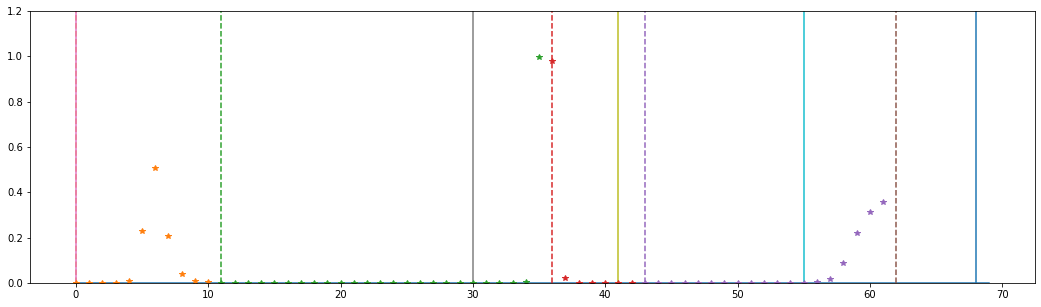

In [31]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1.2

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
#     all_prob.append(segment/torch.sum(segment))
    prob_i = segment / torch.sum(segment)
    prob_i = prob_i.cpu().numpy()
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid][i], loaded_vidid_selected_frames[cur_vidid][i+1])
    plt.plot(xs, prob_i, '*')

plt.ylim([0, ymax])
# all_prob = torch.cat(all_prob).cpu().numpy()
# xs = np.arange(loaded_vidid_selected_frames[cur_vidid][0] + 1, loaded_vidid_selected_frames[cur_vidid][-1])
# plt.plot(xs, all_prob, '-')

In [80]:
cur_vid_feat = torch.softmax(y, dim=1).permute(0,2,1)[idx]
cur_vid_count = item[1][idx]
labels = item[2][idx]

selected_frames = loaded_vidid_selected_frames[cur_vidid]
prob_each_video = prob_video_each_segment_dict[cur_vidid]

log_probs = torch.log(cur_vid_feat + 1e-8)
cumsum_feat = torch.cumsum(log_probs, dim=0)

full_arr = []
for i, cur_ele in enumerate(selected_frames[:-1]):
    next_ele = selected_frames[i + 1]
    label_cur_ele = labels[cur_ele]
    label_next_ele = labels[next_ele]
    prob_list = [] 

    count = 0
    for ele in range(cur_ele, next_ele, 1):
        start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
        sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
        sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
        prob_list.append((sum_window_class_1 + sum_window_class_2)  * (prob_each_video[i][count].item()))
        count = count + 1
    full_arr.append(torch.stack(prob_list))

In [81]:
-torch.mean(torch.cat(full_arr))

tensor(0.3756, device='cuda:0')

In [83]:
label_cur_ele

tensor(14)

In [84]:
label_next_ele

tensor(47)

In [85]:
selected_frames

[0, 10, 18, 60, 102, 183, 198, 242]

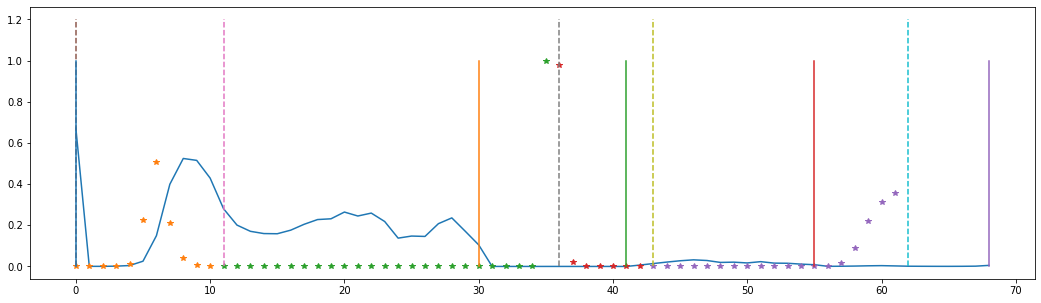

In [32]:
plt_arr = []


for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

all_prob = []
for i, segment in enumerate(prob_each_segment):
#     all_prob.append(segment/torch.sum(segment))
    prob_i = segment / torch.sum(segment)
    prob_i = prob_i.cpu().numpy()
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid][i], loaded_vidid_selected_frames[cur_vidid][i+1])
    plt.plot(xs, prob_i, '*')

for pivot in loaded_vidid_selected_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 1])